<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Recurrent Neural Networks (RNNs)

_Author: Riley Dallas (ATX)_

---


### Learning Objectives

- Learn how to train/test split for sequence data
- Use `TimeseriesGenerator` to prep our time series data for modeling
- Create a basic RNN model using `keras`

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

## Load data: AAPL stock prices and SEC filings
---

There are two datasets that we'll merge together:
- Apple's historical stock prices (ticker: AAPL)
- Their SEC filings:
  - Annual earnings reports: 10-K
  - Quarterly earnings reports: 10-Q
  - Company news and updates: 8-K

Load both in the cells below.

In [12]:
# load prices
prices = pd.read_csv('https://raw.git.generalassemb.ly/DSIR-111/dsir-111/master/week-07/7.06-lesson-rnn/datasets/AAPL.csv?token=AAAIYYA34WUY4E24T3DBFLLBYTAPQ')

prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
1,2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2,2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
3,2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
4,2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [24]:
# load filings
filings = pd.read_csv('https://raw.git.generalassemb.ly/DSIR-111/dsir-111/master/week-07/7.06-lesson-rnn/datasets/filings.csv?token=AAAIYYCVQBSTBIUAIDEEKL3BYTARE')

filings.head()

,Date,10-K,10-Q,8-K
0,1994-12-13,1.0,0.0,0.0
1,1995-12-19,1.0,0.0,0.0
2,1996-12-19,1.0,0.0,0.0
3,1997-12-05,1.0,0.0,0.0
4,1999-12-22,1.0,0.0,0.0


## `Date` columns
---

For both datasets, we need to:
1. Convert the `Date` column to be a `datetime` object
2. Since these are time series datasets, we need the indices to be the `Date` columns

In [14]:
# set prices Date to datetime
prices['Date'] = pd.to_datetime(prices['Date'])

In [15]:
prices.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [16]:
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
1,2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2,2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
3,2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
4,2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [17]:
prices['Date'].dt.year

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
3518    2019
3519    2019
3520    2019
3521    2019
3522    2019
Name: Date, Length: 3523, dtype: int64

In [18]:
prices['Date'].dt.month

0       4
1       4
2       4
3       4
4       4
       ..
3518    4
3519    4
3520    4
3521    4
3522    4
Name: Date, Length: 3523, dtype: int64

In [19]:
# set prices index to Date column
prices = prices.set_index('Date')

prices = prices.sort_index() # rearrange our df , so the index is in ascending order

prices.head()

# got an error because I ran this twice

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [20]:
prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [25]:
# set filings Date to datetime
filings['Date'] = pd.to_datetime(filings['Date'])

In [26]:
filings.dtypes

Date    datetime64[ns]
10-K           float64
10-Q           float64
8-K            float64
dtype: object

In [27]:
# set filings index to Date column

filings = filings.set_index('Date')

filings = filings.sort_index()

filings.head()

,10-K,10-Q,8-K
Date,,,
1994-12-13,1.0,0.0,0.0
1995-12-19,1.0,0.0,0.0
1996-12-19,1.0,0.0,0.0
1997-12-05,1.0,0.0,0.0
1999-12-22,1.0,0.0,0.0


## Data cleaning: Prices
---

For Apple's stock prices, we'll need to do a few things:
1. Drop the `Adj Close` column since we already have a `Close` price
2. De-trend the dataset using `.pct_change()`
3. Drop any `NaN`s that were created from step 2

In [28]:
# Drop Adj Close column
prices = prices.drop(columns = 'Adj Close')

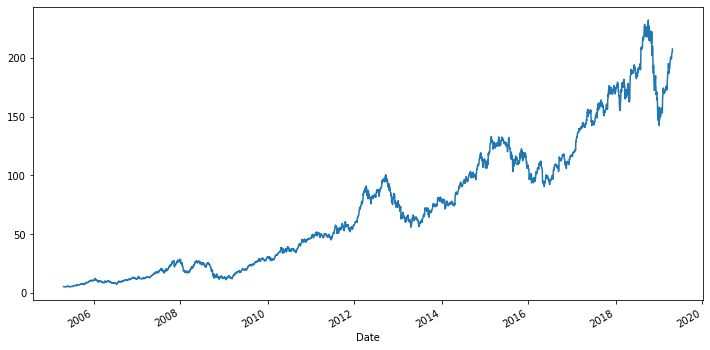

In [29]:
# Plot Close column
prices['Close'].plot(figsize = (12, 6))

In [30]:
# Convert prices to be percent changes from prior row
prices = prices.pct_change()

In [31]:
prices.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-25,NaN,NaN,NaN,NaN,NaN
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838


In [32]:
# Drop nulls

prices = prices.dropna()

In [33]:
prices.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285


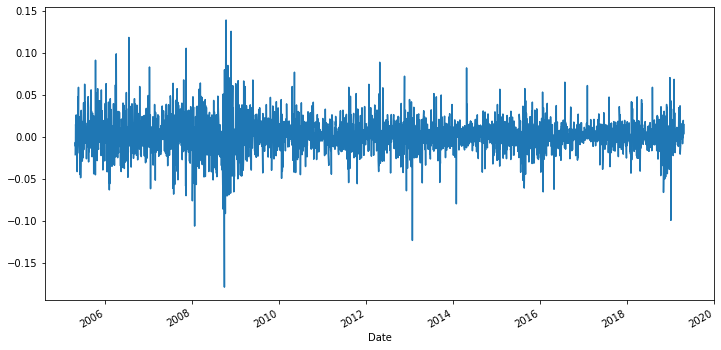

In [34]:
# Plot Close column again
prices['Close'].plot(figsize = (12, 6));

## Create `Target` column
---

Our column of interest is the `Close` prices. We could build a regression model, where we predict the actual percentage change, or we could set this up as a binary classification problem:
- 1: The `Close` price was greater than or equal to the previous day
- 0: The `Close` price was lower than the previous day

We'll go with the latter option. In the cell below, let's create our binary `Target` column.

In [35]:
# Create Target column
prices['Target'] = (prices['Close'] >= 0).astype(int)

In [36]:
prices.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1


## Merge Prices with SEC filings
---

SEC filings tend to have a huge impact on stock prices. Because of this, we'll want to merge the prices and filings `DataFrames` together.

In [37]:
prices.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1


In [38]:
filings.head()

,10-K,10-Q,8-K
Date,,,
1994-12-13,1.0,0.0,0.0
1995-12-19,1.0,0.0,0.0
1996-12-19,1.0,0.0,0.0
1997-12-05,1.0,0.0,0.0
1999-12-22,1.0,0.0,0.0


<details><summary>What kind of join should we use here?</summary>

We'll want to do a left join, so that we don't lose any rows that aren't associated with any SEC filings.
</details>

In [40]:
# Merge DataFrames
df = pd.merge(left = prices, right = filings, left_index = True, right_index = True, how = 'left')

df.head()

,Open,High,Low,Close,Volume,Target,10-K,10-Q,8-K
Date,,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0,NaN,NaN,NaN
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0,NaN,NaN,NaN
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0,NaN,NaN,NaN
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1,NaN,NaN,NaN
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1,NaN,NaN,NaN


## Fill `NaN`s
---

After the merge, we now have a bunch of `NaN`s for rows that didn't have any SEC filings on that date. Let's fill those in with 0.

In [41]:
df.shape

(3522, 9)

In [42]:
df.isna().sum().sort_values(ascending = False)

8-K       3431
10-Q      3431
10-K      3431
Target       0
Volume       0
Close        0
Low          0
High         0
Open         0
dtype: int64

In [43]:
# Fill Nans with 0
df = df.fillna(0)

In [44]:
df.isna().sum().sort_values(ascending = False)

8-K       0
10-Q      0
10-K      0
Target    0
Volume    0
Close     0
Low       0
High      0
Open      0
dtype: int64

In [45]:
df.head()

,Open,High,Low,Close,Volume,Target,10-K,10-Q,8-K
Date,,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0,0.0,0.0,0.0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0,0.0,0.0,0.0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0,0.0,0.0,0.0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1,0.0,0.0,0.0
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1,0.0,0.0,0.0


## Train/Test Split
---

Since we're dealing with time series data, we don't want the model to be able to see the future. 

<details><summary>What do we need to do in train_test_split?</summary>

- set `shuffle=False` so that the order is maintained
</details>

In [46]:
df['Target'].values

array([0, 0, 0, ..., 1, 1, 1])

In [47]:
df[['Target']].values

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [48]:
# Create X and y

features = [col for col in df.columns if not col == 'Target']

X = df[features]

y = df[['Target']].values

In [49]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)

X_train.head()

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
Date,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0.0,0.0,0.0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0.0,0.0,0.0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0.0,0.0,0.0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,0.0,0.0,0.0
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,0.0,0.0,0.0


In [50]:
X_train.tail()

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
Date,,,,,,,,
2015-10-14,0.004241,-0.008270,-0.010119,-0.014134,0.345336,0.0,0.0,0.0
2015-10-15,-0.003235,0.005201,0.008488,0.014971,-0.152689,0.0,0.0,0.0
2015-10-16,0.007662,-0.000892,0.000362,-0.007331,0.041385,0.0,0.0,0.0
2015-10-19,-0.008767,-0.002232,-0.003800,0.006214,-0.241468,0.0,0.0,0.0
2015-10-20,0.004874,0.021655,0.006448,0.018258,0.639117,0.0,0.0,0.0


In [51]:
X_test.head()

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
Date,,,,,,,,
2015-10-21,0.023891,0.012350,0.025988,-0.000088,-0.143169,0.0,0.0,0.0
2015-10-22,0.002895,-0.000692,0.003518,0.015295,-0.003376,0.0,0.0,0.0
2015-10-23,0.020729,0.032294,0.019544,0.030996,0.425235,0.0,0.0,0.0
2015-10-26,0.011825,-0.009226,-0.012121,-0.031911,0.117353,0.0,0.0,0.0
2015-10-27,-0.022696,-0.013460,-0.008093,-0.006332,0.053526,0.0,0.0,1.0


## Scaling
---

You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [52]:
# Scale

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [53]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 3, batch_size = 64)

In [54]:
batch_x, batch_y = train_sequences[0]

In [55]:
batch_x.shape

(64, 3, 8)

In [56]:
batch_y.shape

(64, 1)

In [58]:
# Create test sequences

test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 3, batch_size = 64)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 1 `Dense` output layer

We're doing a binary classification problem.

<details><summary>What should our output layer look like?</summary>

- 1 neuron
- sigmoid activation function
- this way, our model predicts a probability
</details>

In [59]:
y[:5]

array([[0],
       [0],
       [0],
       [1],
       [1]])

In [60]:
# Design RNN

input_shape = batch_x.shape[1:]

model = Sequential()
model.add(GRU(8, input_shape = input_shape, return_sequences=True)) # True when your next layer is also an RNN layer
model.add(GRU(8, return_sequences=False)) # False because next layer is NOT an RNN layer
model.add(Dense(4, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(
    loss = 'bce',
    optimizer = Adam(lr=0.0005),
    metrics = ['acc']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
history = model.fit(train_sequences,
                    validation_data = test_sequences,
                    epochs = 50)

Epoch 1/50
42/42 [==============================] - 11s 54ms/step - loss: 0.6924 - acc: 0.5262 - val_loss: 0.6919 - val_acc: 0.5353
Epoch 2/50
42/42 [==============================] - 1s 13ms/step - loss: 0.6919 - acc: 0.5277 - val_loss: 0.6916 - val_acc: 0.5364
Epoch 3/50
42/42 [==============================] - 1s 13ms/step - loss: 0.6916 - acc: 0.5273 - val_loss: 0.6911 - val_acc: 0.5364
Epoch 4/50
42/42 [==============================] - 1s 13ms/step - loss: 0.6912 - acc: 0.5265 - val_loss: 0.6909 - val_acc: 0.5364
Epoch 5/50
42/42 [==============================] - 1s 15ms/step - loss: 0.6912 - acc: 0.5262 - val_loss: 0.6907 - val_acc: 0.5364
Epoch 6/50
42/42 [==============================] - 1s 15ms/step - loss: 0.6909 - acc: 0.5262 - val_loss: 0.6905 - val_acc: 0.5364
Epoch 7/50
42/42 [==============================] - 1s 18ms/step - loss: 0.6908 - acc: 0.5262 - val_loss: 0.6905 - val_acc: 0.5364
Epoch 8/50
42/42 [==============================] - 1s 15ms/step - loss: 0.6907 - 

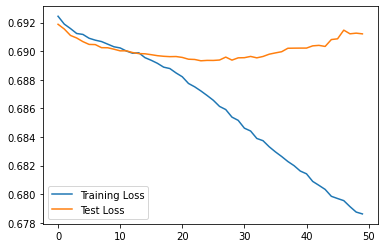

In [62]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend();

## Your turn!
---

Can you improve this model? Try to build a model that minimizes the testing loss even more!